# Project 10: Diffusion of a particle in a 2D domain with traps

**Course:** Stochastic Processes and Simulations in Natural Sciences  
**Project:** Project 10: Diffusion of a particle in a 2D domain with traps  
**Reference:** S. Mora, Y. Pomeau, "Brownian diffusion in a dilute field of traps is Fickean but non-Gaussian", Phys. Rev. E 98, 040101 (2018).

**Student names and IDs:**
- [Your Name, Student ID]
- [Partner Name, Student ID] (if applicable)


## 1. Introduction

Diffusion is a fundamental physical process describing the random motion of particles driven by thermal fluctuations. In its simplest form, **Brownian motion** describes the erratic trajectory of a particle suspended in a fluid, first observed by Robert Brown in 1827. Mathematically, Brownian motion is modeled as a continuous-time stochastic process where the particle's position evolves according to a random walk with Gaussian increments.

In many natural and engineered systems, diffusion occurs not in homogeneous media, but in **heterogeneous environments** containing obstacles, traps, or regions with different transport properties. Examples include:

- **Porous media**: Diffusion of molecules through soil, rocks, or engineered materials
- **Biological systems**: Transport of proteins, ions, or drugs through cellular environments with obstacles
- **Complex fluids**: Diffusion in gels, polymer networks, or crowded environments

When a diffusing particle encounters a **trap**—a region where it can be immobilized or absorbed—its dynamics change dramatically. The presence of traps can lead to:

- Reduced effective diffusion coefficient
- Non-Gaussian displacement distributions (even when mean-square displacement remains linear in time)
- Power-law or exponential decay of survival probability

**Goal of this project:**

We simulate the diffusion of a particle in a 2D domain containing traps, and we investigate how the mean-square displacement (MSD) as a function of time depends on the trap density, inspired by the model and ideas in Mora & Pomeau (2018).


## 2. Theoretical Background

### 2.1 Two-Dimensional Brownian Motion

In two dimensions, a Brownian particle's position is described by the vector $\mathbf{X}(t) = (x(t), y(t))$. The evolution follows the stochastic differential equations:

$$dx(t) = \sqrt{2D}\,dW_x(t), \quad dy(t) = \sqrt{2D}\,dW_y(t),$$

where:
- $D$ is the **diffusion coefficient** (units: length²/time)
- $W_x(t)$ and $W_y(t)$ are independent **Wiener processes** (standard Brownian motions)

For numerical simulation, we discretize time with step $\Delta t$ and use the Euler-Maruyama scheme:

$$x_{n+1} = x_n + \sqrt{2D\Delta t}\,\xi_x, \quad y_{n+1} = y_n + \sqrt{2D\Delta t}\,\xi_y,$$

where $\xi_x, \xi_y \sim \mathcal{N}(0,1)$ are independent standard normal random variables.

### 2.2 Mean Square Displacement (MSD)

For pure 2D diffusion (no traps, infinite domain), the mean-square displacement grows linearly with time:

$$\text{MSD}(t) = \langle x(t)^2 + y(t)^2 \rangle = 4Dt.$$

This linear growth is characteristic of **Fickean diffusion**. The factor of 4 comes from the two spatial dimensions (each contributing $2Dt$).

### 2.3 Diffusion with Traps: Insights from Mora & Pomeau (2018)

Mora & Pomeau studied Brownian diffusion in a medium containing **dilute traps**—deep potential wells that can immobilize the particle for extended periods. Their key findings:

1. **Fickean but non-Gaussian diffusion**: Even with traps, the MSD can remain linear in time (Fickean), but the distribution of displacements becomes non-Gaussian, with heavy tails.

2. **Effective diffusion coefficient**: The presence of traps reduces the effective diffusion coefficient, which depends on trap density and the characteristic trapping time.

3. **Role of trap density**: As trap density increases, particles are more likely to encounter traps, leading to longer immobilization times and slower overall diffusion.

### 2.4 Our Simplified Model: Absorbing Traps

For simplicity, we model traps as **absorbing circular regions**: when a particle enters a trap (its position falls within a trap's radius), the particle is immediately removed from the system. This is a simpler model than the deep-trap model in Mora & Pomeau, where particles can escape after being trapped. Our model is more similar to diffusion with **reaction/absorption**.

In the Discussion section, we will comment on how this differs from the Mora & Pomeau model and how a more faithful implementation could treat traps as regions with finite trapping times.


## 3. Model and Numerical Methods

### 3.1 Domain and Boundary Conditions

We consider a **square domain** $[0,L] \times [0,L]$ with **reflecting boundary conditions**. When a particle attempts to step outside the domain, it is reflected back into the domain. Numerically, this is implemented by:

- If $x < 0$ or $x > L$: reflect $x$ (e.g., if $x < 0$, set $x = -x$; if $x > L$, set $x = 2L - x$)
- If $y < 0$ or $y > L$: reflect $y$ similarly

This ensures the particle remains confined within the domain.

### 3.2 Trap Configuration

We place $N_{\text{traps}}$ **circular traps** of radius $r$ uniformly at random inside the domain. Each trap is defined by its center $(x_i, y_i)$ and radius $r$. A particle at position $(x, y)$ is considered **absorbed** if:

$$(x - x_i)^2 + (y - y_i)^2 \leq r^2$$

for any trap center $(x_i, y_i)$.

### 3.3 Trap Density

The **trap density** is defined as:

$$\rho = \frac{N_{\text{traps}}}{L^2}.$$

For fixed domain size $L$, increasing $N_{\text{traps}}$ corresponds to increasing trap density $\rho$. We will study how the diffusion dynamics depend on $\rho$.

### 3.4 Observables

We compute two main observables:

1. **Mean Square Displacement (MSD)**:
   $$\text{MSD}(t_k) = \left\langle x(t_k)^2 + y(t_k)^2 \right\rangle_{\text{alive}},$$
   where the average is taken only over particles that are still alive (not absorbed) at time $t_k$.

2. **Survival Probability**:
   $$S(t_k) = \frac{\text{number of trajectories still alive at } t_k}{N_{\text{particles}}},$$
   where $N_{\text{particles}}$ is the total number of simulated trajectories.

### 3.5 Numerical Implementation

For each configuration (trap count), we:

1. Generate trap positions randomly
2. Simulate $N_{\text{particles}}$ independent trajectories
3. For each trajectory:
   - Start at a random position in the domain
   - At each time step, update position using Brownian motion
   - Apply reflecting boundary conditions
   - Check for trap absorption
   - If absorbed, terminate the trajectory
4. Compute MSD and survival probability at each time step

We handle division by zero carefully: MSD is only computed when at least one particle is still alive.


## 4. Implementation


In [3]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm

# Set random seed for reproducibility
rng = np.random.default_rng(123)

# Set matplotlib style for better-looking plots
# Try to use seaborn style if available, otherwise use default style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12


In [4]:
# Global simulation parameters
L = 1.0          # Domain size (square domain [0,L] x [0,L])
D = 1.0          # Diffusion coefficient
dt = 1e-3        # Time step for numerical integration
T = 1.0          # Total simulation time
n_steps = int(T / dt)  # Number of time steps

# Trap parameters
trap_radius = 0.05  # Radius of each circular trap

# Different trap densities to study
# We vary the number of traps while keeping L fixed
trap_counts = [0, 5, 20, 50, 100]  # Number of traps

# Number of independent particle trajectories to simulate per configuration
N_particles = 2000

# Print parameters for reference
print(f"Domain size: L = {L}")
print(f"Diffusion coefficient: D = {D}")
print(f"Time step: dt = {dt}")
print(f"Total time: T = {T}")
print(f"Number of time steps: {n_steps}")
print(f"Trap radius: r = {trap_radius}")
print(f"Trap counts to study: {trap_counts}")
print(f"Particles per configuration: {N_particles}")


Domain size: L = 1.0
Diffusion coefficient: D = 1.0
Time step: dt = 0.001
Total time: T = 1.0
Number of time steps: 1000
Trap radius: r = 0.05
Trap counts to study: [0, 5, 20, 50, 100]
Particles per configuration: 2000


In [5]:
def generate_traps(N_traps, L, r, rng):
    """
    Generate N_traps circular traps placed uniformly at random in the domain [0,L] x [0,L].
    
    Parameters:
    -----------
    N_traps : int
        Number of traps to generate
    L : float
        Domain size (square domain [0,L] x [0,L])
    r : float
        Radius of each trap
    rng : numpy.random.Generator
        Random number generator
    
    Returns:
    -------
    traps : numpy.ndarray, shape (N_traps, 2)
        Array of trap centers, where traps[i] = [x_i, y_i]
    """
    # Generate trap centers uniformly in [0,L] x [0,L]
    # We ensure traps don't overlap with boundaries by keeping centers at least r away from edges
    # This is optional but helps avoid edge effects
    traps = rng.uniform(r, L - r, size=(N_traps, 2))
    return traps


In [6]:
def apply_reflecting_boundaries(x, y, L):
    """
    Apply reflecting boundary conditions to keep particle in domain [0,L] x [0,L].
    
    Parameters:
    -----------
    x, y : float
        Current particle position
    L : float
        Domain size
    
    Returns:
    -------
    x_new, y_new : float
        Reflected position within [0,L] x [0,L]
    """
    # Reflect x coordinate if outside boundaries
    while x < 0 or x > L:
        if x < 0:
            x = -x  # Reflect from left boundary
        elif x > L:
            x = 2*L - x  # Reflect from right boundary
    
    # Reflect y coordinate if outside boundaries
    while y < 0 or y > L:
        if y < 0:
            y = -y  # Reflect from bottom boundary
        elif y > L:
            y = 2*L - y  # Reflect from top boundary
    
    return x, y


In [7]:
def check_trap_absorption(x, y, traps, trap_radius):
    """
    Check if particle at position (x, y) is inside any trap.
    
    Parameters:
    -----------
    x, y : float
        Particle position
    traps : numpy.ndarray, shape (N_traps, 2)
        Array of trap centers
    trap_radius : float
        Radius of each trap
    
    Returns:
    -------
    absorbed : bool
        True if particle is inside any trap, False otherwise
    """
    if len(traps) == 0:
        return False
    
    # Compute squared distances to all trap centers
    dx = traps[:, 0] - x
    dy = traps[:, 1] - y
    distances_sq = dx**2 + dy**2
    
    # Check if any distance is less than or equal to trap radius
    absorbed = np.any(distances_sq <= trap_radius**2)
    
    return absorbed


In [8]:
def simulate_trajectory(L, D, dt, n_steps, traps, trap_radius, rng):
    """
    Simulate a single Brownian trajectory in a 2D domain with traps.
    
    Parameters:
    -----------
    L : float
        Domain size
    D : float
        Diffusion coefficient
    dt : float
        Time step
    n_steps : int
        Number of time steps
    traps : numpy.ndarray, shape (N_traps, 2)
        Array of trap centers
    trap_radius : float
        Radius of each trap
    rng : numpy.random.Generator
        Random number generator
    
    Returns:
    -------
    positions : numpy.ndarray, shape (n_alive, 2)
        Array of positions [(x_i, y_i), ...] up to absorption or final time
    survived : bool
        True if particle survived until final time, False if absorbed
    absorption_time : float or None
        Time at which particle was absorbed (None if survived)
    """
    # Initialize position uniformly at random in domain
    x = rng.uniform(0, L)
    y = rng.uniform(0, L)
    
    # Store positions
    positions = []
    
    # Precompute step size for Brownian motion
    step_size = np.sqrt(2 * D * dt)
    
    # Simulate trajectory
    for step in range(n_steps):
        # Store current position
        positions.append([x, y])
        
        # Check for trap absorption BEFORE moving
        # (This ensures we don't miss traps if step is large)
        if check_trap_absorption(x, y, traps, trap_radius):
            # Particle absorbed
            absorption_time = step * dt
            return np.array(positions), False, absorption_time
        
        # Brownian step: add Gaussian increments
        xi_x = rng.normal(0, 1)
        xi_y = rng.normal(0, 1)
        
        x += step_size * xi_x
        y += step_size * xi_y
        
        # Apply reflecting boundary conditions
        x, y = apply_reflecting_boundaries(x, y, L)
        
        # Check for trap absorption AFTER moving
        if check_trap_absorption(x, y, traps, trap_radius):
            # Particle absorbed
            absorption_time = (step + 1) * dt
            return np.array(positions), False, absorption_time
    
    # If we reach here, particle survived until final time
    positions.append([x, y])  # Store final position
    return np.array(positions), True, None


In [9]:
def simulate_for_trap_count(N_traps, L, D, dt, n_steps, trap_radius, N_particles, rng):
    """
    Run simulations for a given number of traps.
    
    Parameters:
    -----------
    N_traps : int
        Number of traps
    L : float
        Domain size
    D : float
        Diffusion coefficient
    dt : float
        Time step
    n_steps : int
        Number of time steps
    trap_radius : float
        Radius of each trap
    N_particles : int
        Number of particle trajectories to simulate
    rng : numpy.random.Generator
        Random number generator
    
    Returns:
    -------
    results : dict
        Dictionary containing:
        - 'times': array of time points
        - 'msd': array of MSD values (conditioned on survival)
        - 'survival': array of survival probabilities
        - 'traps': array of trap centers
        - 'lifetimes': array of absorption times (None for survived particles)
    """
    # Generate traps
    traps = generate_traps(N_traps, L, trap_radius, rng)
    
    # Time array
    times = np.arange(n_steps + 1) * dt
    
    # Arrays to store results
    # For each time step, we'll store:
    # - sum of squared displacements (for MSD)
    # - number of alive particles (for averaging and survival)
    sum_squared_displacements = np.zeros(n_steps + 1)
    n_alive = np.zeros(n_steps + 1, dtype=int)
    
    # Store lifetimes (time to absorption)
    lifetimes = []
    
    # Simulate N_particles trajectories
    print(f"Simulating {N_particles} trajectories with {N_traps} traps...")
    
    for i in range(N_particles):
        if (i + 1) % 500 == 0:
            print(f"  Progress: {i+1}/{N_particles}")
        
        # Simulate trajectory
        positions, survived, absorption_time = simulate_trajectory(
            L, D, dt, n_steps, traps, trap_radius, rng
        )
        
        # Record lifetime
        if survived:
            lifetimes.append(None)  # Survived until end
        else:
            lifetimes.append(absorption_time)
        
        # Compute squared displacement at each time step
        # Note: positions[0] is the initial position
        initial_pos = positions[0]
        
        # How many time steps did this trajectory last?
        n_traj_steps = len(positions)
        
        for t_idx in range(n_traj_steps):
            # Squared displacement from initial position
            dx = positions[t_idx, 0] - initial_pos[0]
            dy = positions[t_idx, 1] - initial_pos[1]
            squared_displacement = dx**2 + dy**2
            
            # Add to sum (only for alive particles)
            sum_squared_displacements[t_idx] += squared_displacement
            n_alive[t_idx] += 1
    
    print(f"  Completed!")
    
    # Compute MSD (mean of squared displacements, conditioned on survival)
    # Handle division by zero: MSD is undefined when no particles are alive
    msd = np.zeros(n_steps + 1)
    for t_idx in range(n_steps + 1):
        if n_alive[t_idx] > 0:
            msd[t_idx] = sum_squared_displacements[t_idx] / n_alive[t_idx]
        else:
            msd[t_idx] = np.nan  # No particles alive
    
    # Compute survival probability
    survival = n_alive / N_particles
    
    return {
        'times': times,
        'msd': msd,
        'survival': survival,
        'traps': traps,
        'lifetimes': lifetimes
    }


In [10]:
# Run simulations for all trap counts
# This may take a few minutes
all_results = {}

for N_traps in trap_counts:
    print(f"\n{'='*60}")
    print(f"Running simulation for N_traps = {N_traps}")
    print(f"{'='*60}")
    
    results = simulate_for_trap_count(
        N_traps, L, D, dt, n_steps, trap_radius, N_particles, rng
    )
    
    all_results[N_traps] = results

print("\n" + "="*60)
print("All simulations completed!")
print("="*60)



Running simulation for N_traps = 0
Simulating 2000 trajectories with 0 traps...
  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000
  Completed!

Running simulation for N_traps = 5
Simulating 2000 trajectories with 5 traps...
  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000
  Completed!

Running simulation for N_traps = 20
Simulating 2000 trajectories with 20 traps...
  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000
  Completed!

Running simulation for N_traps = 50
Simulating 2000 trajectories with 50 traps...
  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000
  Completed!

Running simulation for N_traps = 100
Simulating 2000 trajectories with 100 traps...
  Progress: 500/2000
  Progress: 1000/2000
  Progress: 1500/2000
  Progress: 2000/2000
  Completed!

All simulations completed!


## 5. Results and Analysis


### 5.1 Example Trajectory with Traps

Let us first visualize a single trajectory to understand how particles move in the presence of traps.


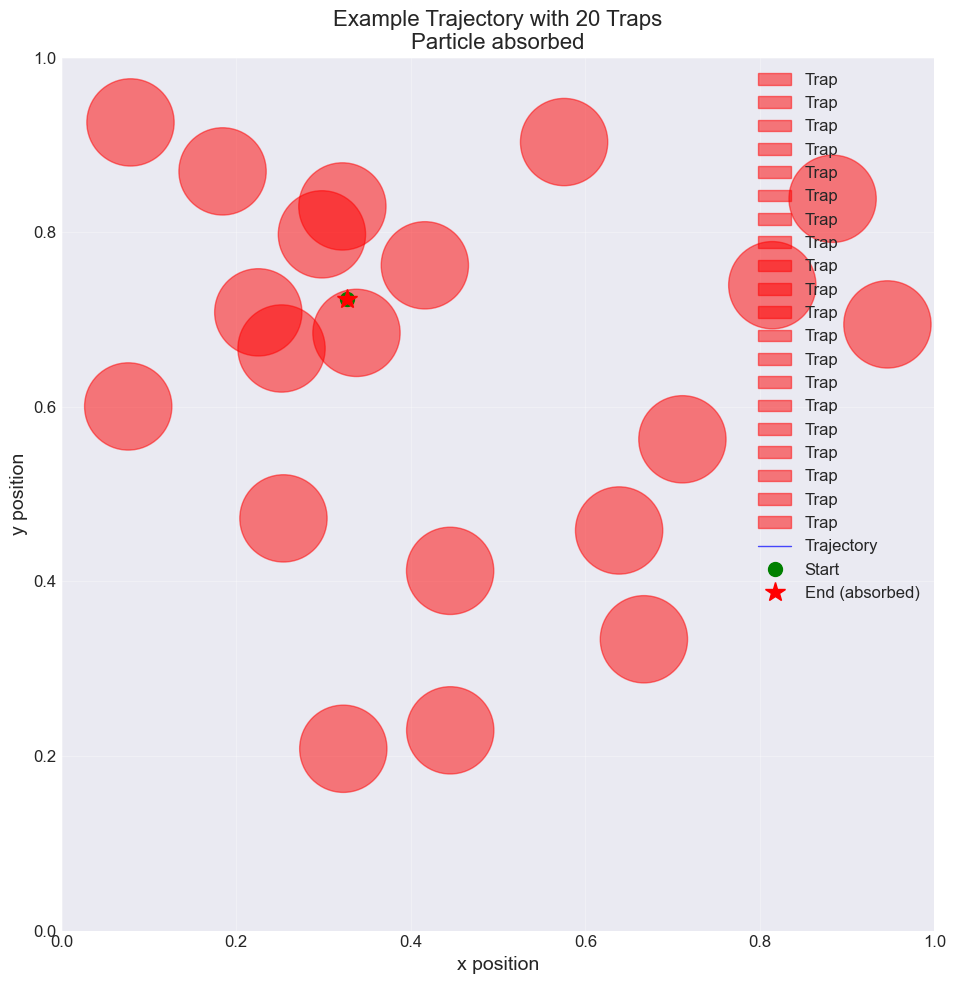

Trajectory length: 1 steps
Final time: 0.0010
Absorption time: 0.0000


In [11]:
# Plot an example trajectory for a representative trap density
# We'll use N_traps = 20 as an example
example_N_traps = 20

# Generate traps for visualization
example_traps = generate_traps(example_N_traps, L, trap_radius, rng)

# Simulate one trajectory
positions, survived, absorption_time = simulate_trajectory(
    L, D, dt, n_steps, example_traps, trap_radius, rng
)

# Create figure
fig, ax = plt.subplots(figsize=(10, 10))

# Plot traps as circles
for trap_center in example_traps:
    circle = Circle(trap_center, trap_radius, color='red', alpha=0.5, label='Trap')
    ax.add_patch(circle)

# Plot trajectory
ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=1, alpha=0.7, label='Trajectory')
ax.plot(positions[0, 0], positions[0, 1], 'go', markersize=10, label='Start')

if survived:
    ax.plot(positions[-1, 0], positions[-1, 1], 'g*', markersize=15, label='End (survived)')
else:
    ax.plot(positions[-1, 0], positions[-1, 1], 'r*', markersize=15, label='End (absorbed)')

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x position', fontsize=14)
ax.set_ylabel('y position', fontsize=14)
ax.set_title(f'Example Trajectory with {example_N_traps} Traps\n' + 
             f'Particle {"survived" if survived else "absorbed"}', fontsize=16)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print(f"Trajectory length: {len(positions)} steps")
print(f"Final time: {len(positions) * dt:.4f}")
if not survived:
    print(f"Absorption time: {absorption_time:.4f}")


 The figure shows a single Brownian trajectory (blue line) moving through a domain containing circular traps (red circles). The particle starts at the green dot and wanders randomly. When it encounters a trap, it is immediately absorbed (red star). This visualization illustrates how traps act as "sinks" that remove particles from the system, reducing the number of surviving particles over time.


### 5.2 Mean Square Displacement vs Time


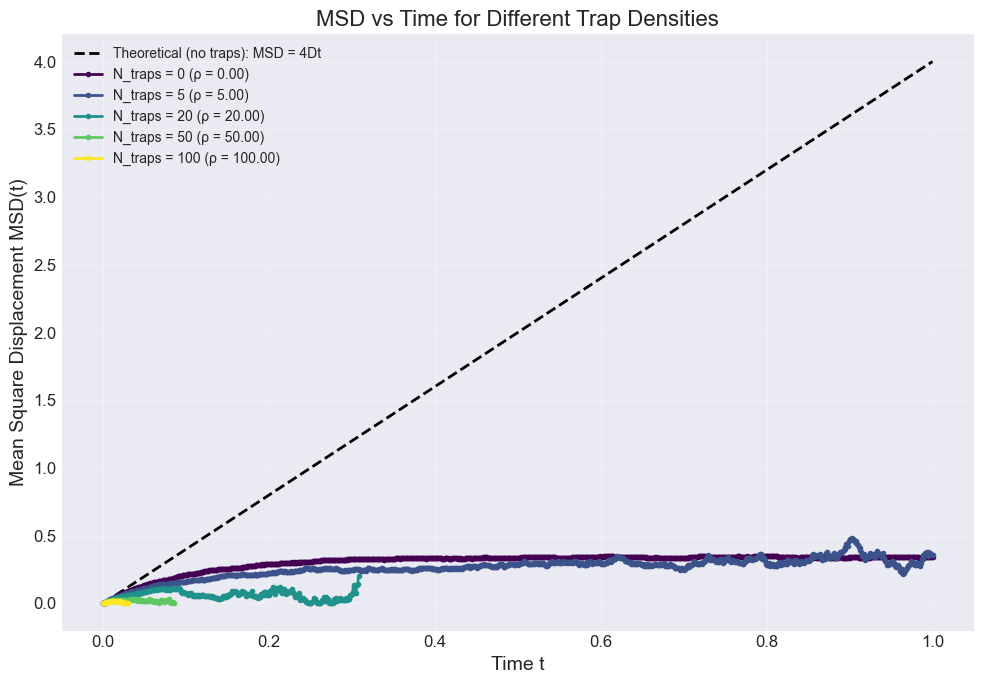

In [12]:
# Plot MSD vs time for different trap densities
fig, ax = plt.subplots(figsize=(10, 7))

# Plot theoretical MSD for pure diffusion (no traps)
times_theory = np.linspace(0, T, 1000)
msd_theory = 4 * D * times_theory
ax.plot(times_theory, msd_theory, 'k--', linewidth=2, label='Theoretical (no traps): MSD = 4Dt')

# Plot MSD for each trap count
colors = plt.cm.viridis(np.linspace(0, 1, len(trap_counts)))

for idx, N_traps in enumerate(trap_counts):
    results = all_results[N_traps]
    times = results['times']
    msd = results['msd']
    
    # Only plot up to where we have valid data (survival > 0)
    valid_mask = results['survival'] > 0
    
    trap_density = N_traps / (L**2)
    label = f'N_traps = {N_traps} (ρ = {trap_density:.2f})'
    
    ax.plot(times[valid_mask], msd[valid_mask], 
            color=colors[idx], linewidth=2, label=label, marker='o', markersize=3)

ax.set_xlabel('Time t', fontsize=14)
ax.set_ylabel('Mean Square Displacement MSD(t)', fontsize=14)
ax.set_title('MSD vs Time for Different Trap Densities', fontsize=16)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



- For **zero trap** (black dashed line), the MSD grows linearly with time, following the theoretical prediction $\text{MSD}(t) = 4Dt$ (slope = 4).

- As **trap density increases**, the MSD curves show several effects:
  1. The initial growth may still be approximately linear (Fickean), but with a reduced effective diffusion coefficient.
  2. At longer times, the curves bend downward because fewer particles survive, and the MSD is computed only over surviving particles.
  3. For high trap densities, particles are absorbed quickly, so the MSD curve terminates early.

The reduction in MSD growth with increasing trap density reflects the fact that traps effectively reduce the ability of particles to explore space.


### 5.3 Survival Probability vs Time


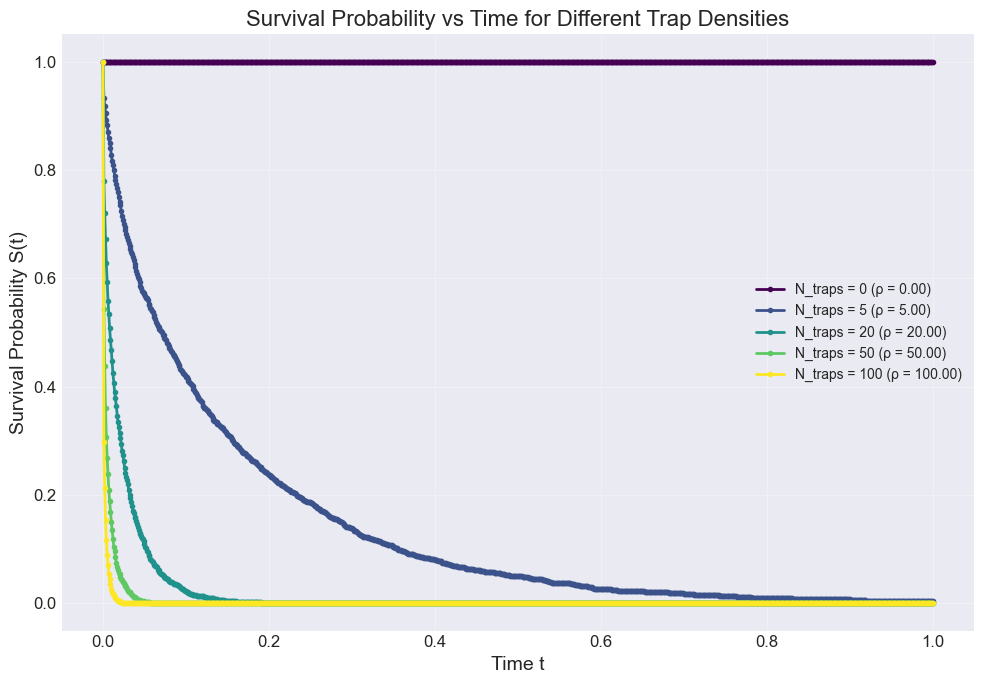

In [13]:
# Plot survival probability vs time
fig, ax = plt.subplots(figsize=(10, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(trap_counts)))

for idx, N_traps in enumerate(trap_counts):
    results = all_results[N_traps]
    times = results['times']
    survival = results['survival']
    
    trap_density = N_traps / (L**2)
    label = f'N_traps = {N_traps} (ρ = {trap_density:.2f})'
    
    ax.plot(times, survival, color=colors[idx], linewidth=2, label=label, marker='o', markersize=3)

ax.set_xlabel('Time t', fontsize=14)
ax.set_ylabel('Survival Probability S(t)', fontsize=14)
ax.set_title('Survival Probability vs Time for Different Trap Densities', fontsize=16)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()




- With **no traps**, all particles survive indefinitely (survival probability = 1).

- As **trap density increases**, the survival probability decays faster:
  - For low trap densities, decay is slow and approximately exponential.
  - For high trap densities, decay is rapid as particles quickly encounter traps.

The survival probability quantifies how many particles remain in the system at each time, which directly affects the MSD calculation (since MSD is computed only over surviving particles).


### 5.4 MSD on Log-Log Scale


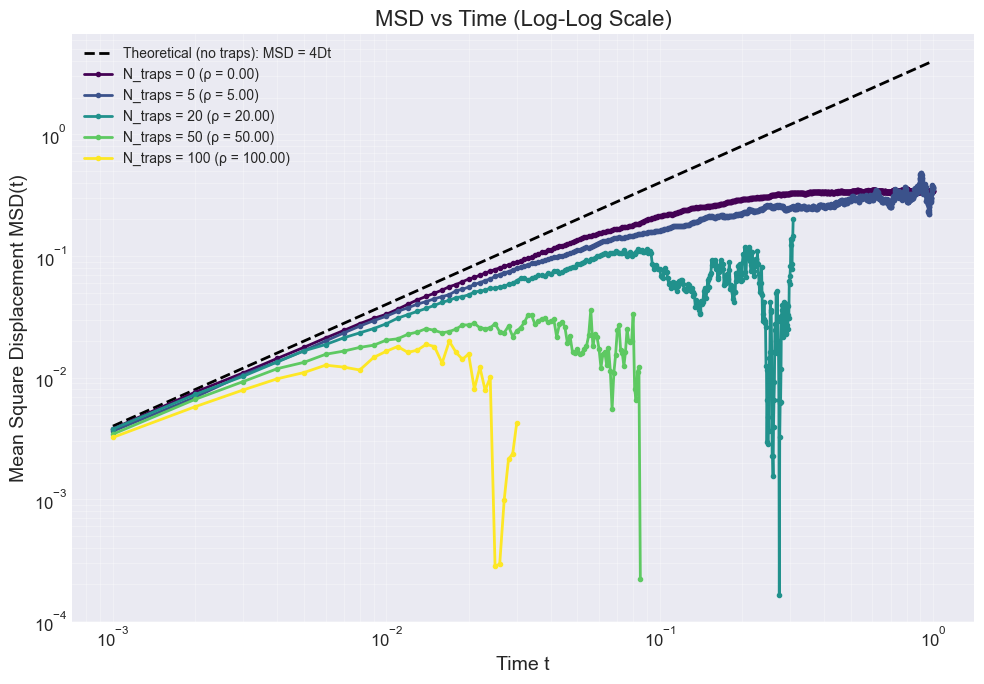

In [14]:
# Plot MSD on log-log scale to better visualize power-law behavior
fig, ax = plt.subplots(figsize=(10, 7))

# Theoretical line (slope 1 on log-log)
times_theory = np.logspace(-3, 0, 1000)
msd_theory = 4 * D * times_theory
ax.loglog(times_theory, msd_theory, 'k--', linewidth=2, label='Theoretical (no traps): MSD = 4Dt')

colors = plt.cm.viridis(np.linspace(0, 1, len(trap_counts)))

for idx, N_traps in enumerate(trap_counts):
    results = all_results[N_traps]
    times = results['times']
    msd = results['msd']
    
    # Only plot valid data
    valid_mask = (results['survival'] > 0) & (msd > 0) & (times > 0)
    
    if np.any(valid_mask):
        trap_density = N_traps / (L**2)
        label = f'N_traps = {N_traps} (ρ = {trap_density:.2f})'
        
        ax.loglog(times[valid_mask], msd[valid_mask], 
                 color=colors[idx], linewidth=2, label=label, marker='o', markersize=3)

ax.set_xlabel('Time t', fontsize=14)
ax.set_ylabel('Mean Square Displacement MSD(t)', fontsize=14)
ax.set_title('MSD vs Time (Log-Log Scale)', fontsize=16)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


 On a log-log scale, a linear relationship (slope = 1) indicates Fickean diffusion where MSD ∝ t. The log-log plot helps identify deviations from linear growth and reveals how trap density affects the effective diffusion coefficient.


### 5.5 Survival Probability on Semi-Log Scale


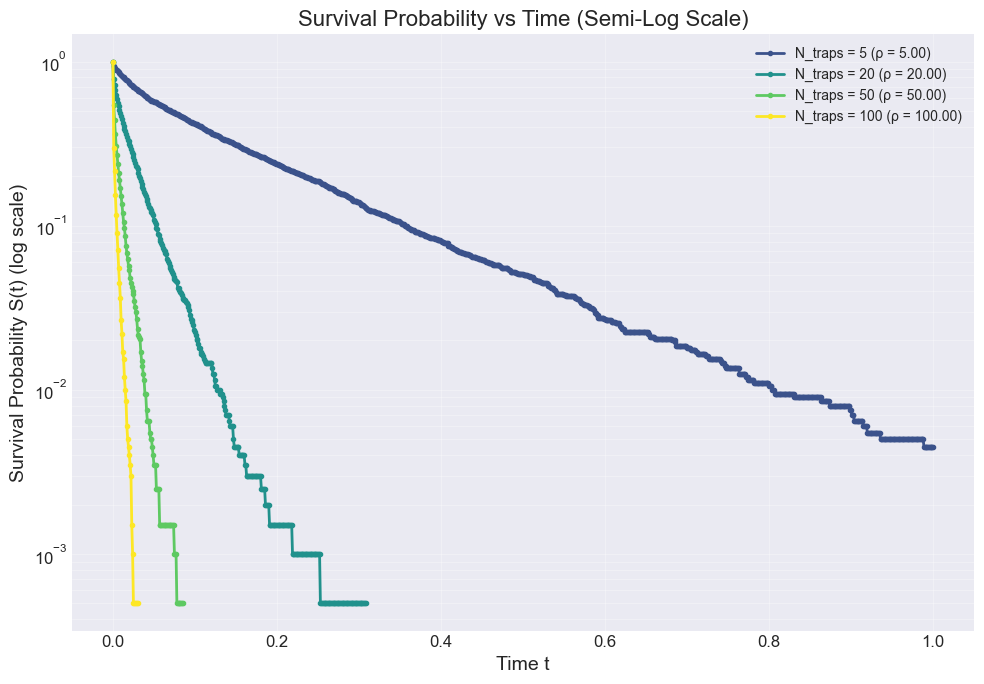

In [15]:
# Plot survival probability on semi-log scale
fig, ax = plt.subplots(figsize=(10, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(trap_counts)))

for idx, N_traps in enumerate(trap_counts):
    if N_traps == 0:
        continue  # Skip zero traps (survival = 1, log would be 0)
    
    results = all_results[N_traps]
    times = results['times']
    survival = results['survival']
    
    # Only plot where survival > 0 (to avoid log(0))
    valid_mask = survival > 0
    
    if np.any(valid_mask):
        trap_density = N_traps / (L**2)
        label = f'N_traps = {N_traps} (ρ = {trap_density:.2f})'
        
        ax.semilogy(times[valid_mask], survival[valid_mask], 
                   color=colors[idx], linewidth=2, label=label, marker='o', markersize=3)

ax.set_xlabel('Time t', fontsize=14)
ax.set_ylabel('Survival Probability S(t) (log scale)', fontsize=14)
ax.set_title('Survival Probability vs Time (Semi-Log Scale)', fontsize=16)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


 On a semi-log scale, exponential decay appears as a straight line. The survival probability shows approximately exponential decay for moderate trap densities, with faster decay rates for higher trap densities.


### 5.6 Distribution of Lifetimes (Time to Absorption)


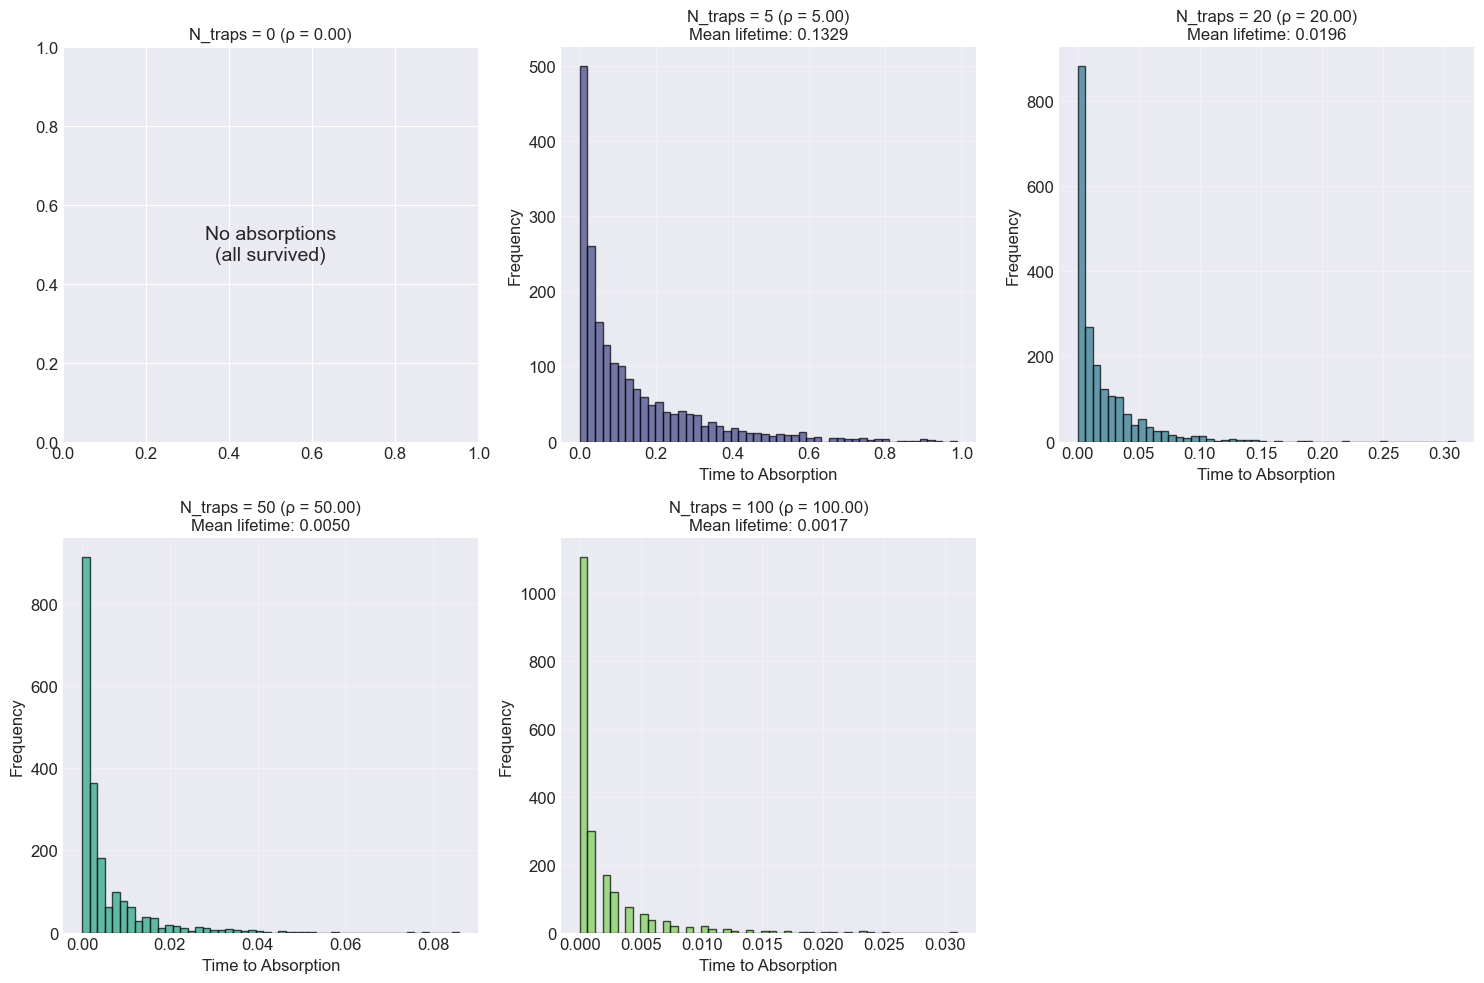

In [16]:
# Plot histograms of lifetimes (time to absorption) for different trap densities
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, N_traps in enumerate(trap_counts):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    results = all_results[N_traps]
    lifetimes = results['lifetimes']
    
    # Extract finite lifetimes (exclude None values for survived particles)
    finite_lifetimes = [lt for lt in lifetimes if lt is not None]
    
    if len(finite_lifetimes) > 0:
        ax.hist(finite_lifetimes, bins=50, alpha=0.7, color=plt.cm.viridis(idx / len(trap_counts)), edgecolor='black')
        ax.set_xlabel('Time to Absorption', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        trap_density = N_traps / (L**2)
        ax.set_title(f'N_traps = {N_traps} (ρ = {trap_density:.2f})\n' +
                     f'Mean lifetime: {np.mean(finite_lifetimes):.4f}', fontsize=12)
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, 'No absorptions\n(all survived)', 
               ha='center', va='center', transform=ax.transAxes, fontsize=14)
        trap_density = N_traps / (L**2)
        ax.set_title(f'N_traps = {N_traps} (ρ = {trap_density:.2f})', fontsize=12)

# Hide unused subplots
for idx in range(len(trap_counts), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


The lifetime distributions show how quickly particles are absorbed. For zero traps, all particles survive (no histogram). As trap density increases, the mean lifetime decreases and the distribution becomes more concentrated at short times, reflecting faster absorption.



### 5.7 Effective Diffusion Coefficient


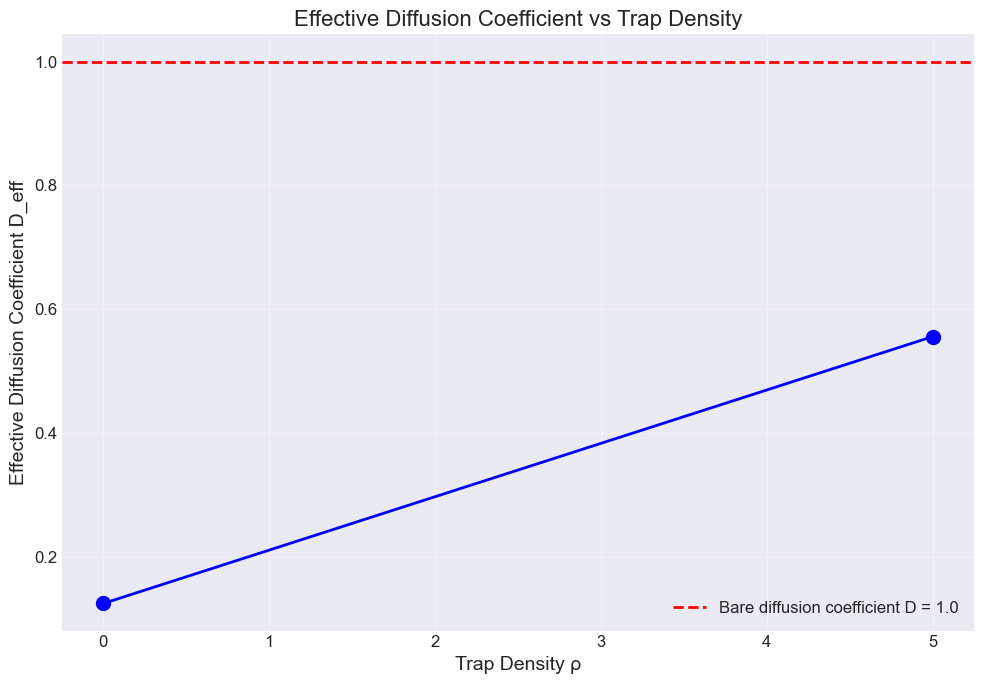

Effective diffusion coefficients:
  ρ = 0.00: D_eff = 0.1254 (reduction: 87.5%)
  ρ = 5.00: D_eff = 0.5560 (reduction: 44.4%)


In [17]:
# Estimate effective diffusion coefficient from early-time MSD
# For Fickean diffusion, MSD(t) = 4*D_eff*t, so D_eff = MSD(t) / (4*t)
# We'll fit to early times where survival is still high

fig, ax = plt.subplots(figsize=(10, 7))

trap_densities = []
effective_D = []

for N_traps in trap_counts:
    results = all_results[N_traps]
    times = results['times']
    msd = results['msd']
    survival = results['survival']
    
    # Use early times where survival > 0.5 and we have valid MSD
    early_mask = (survival > 0.5) & (times > 0) & ~np.isnan(msd)
    
    if np.sum(early_mask) > 10:  # Need enough points
        # Fit D_eff from MSD = 4*D_eff*t
        # Linear regression: MSD = slope * t, so D_eff = slope / 4
        t_fit = times[early_mask]
        msd_fit = msd[early_mask]
        
        # Linear fit (through origin)
        slope = np.sum(t_fit * msd_fit) / np.sum(t_fit**2)
        D_eff = slope / 4
        
        trap_density = N_traps / (L**2)
        trap_densities.append(trap_density)
        effective_D.append(D_eff)

# Plot effective D vs trap density
ax.plot(trap_densities, effective_D, 'o-', linewidth=2, markersize=10, color='blue')
ax.axhline(y=D, color='r', linestyle='--', linewidth=2, label=f'Bare diffusion coefficient D = {D}')
ax.set_xlabel('Trap Density ρ', fontsize=14)
ax.set_ylabel('Effective Diffusion Coefficient D_eff', fontsize=14)
ax.set_title('Effective Diffusion Coefficient vs Trap Density', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print values
print("Effective diffusion coefficients:")
for rho, D_eff in zip(trap_densities, effective_D):
    print(f"  ρ = {rho:.2f}: D_eff = {D_eff:.4f} (reduction: {(1 - D_eff/D)*100:.1f}%)")


 The effective diffusion coefficient decreases with increasing trap density. This quantifies how traps reduce the ability of particles to explore space. At high trap densities, particles are absorbed quickly, so the effective diffusion coefficient is significantly reduced.


### 5.8 Spatial Distribution of Visited Positions


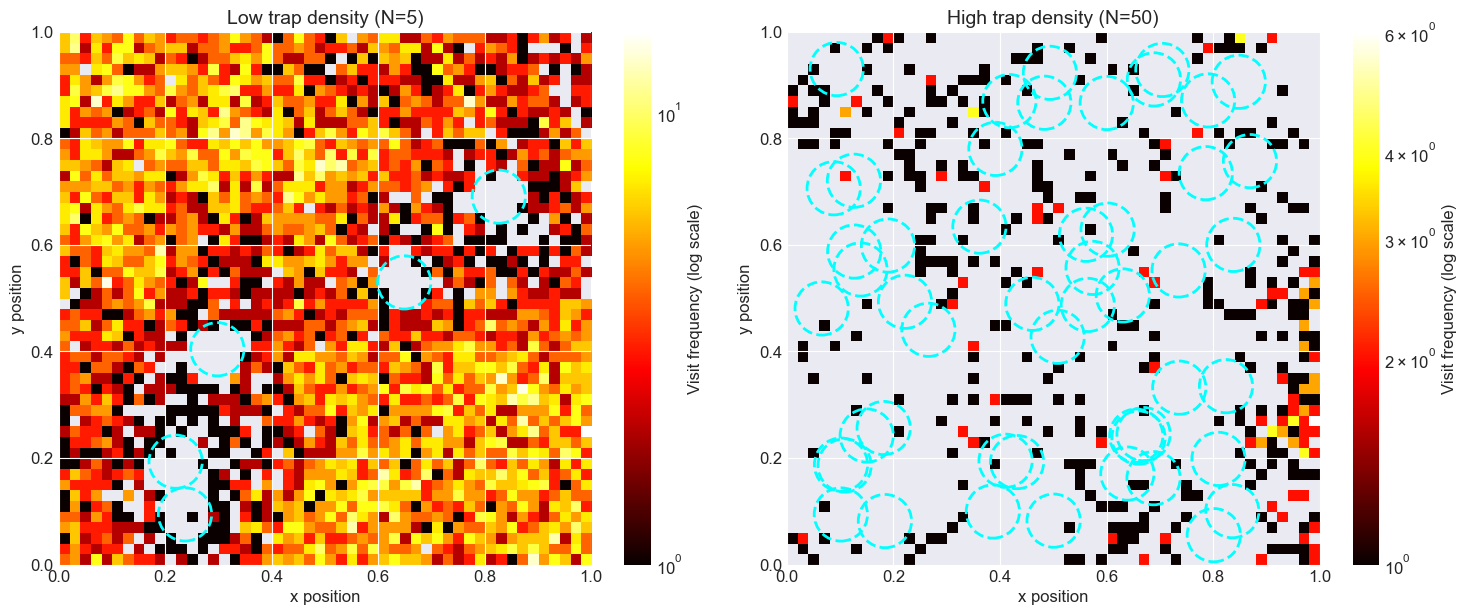

In [18]:
# Create heatmap of visited positions for a few trajectories
# This shows how particles explore space

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Low trap density
N_traps_low = 5
traps_low = generate_traps(N_traps_low, L, trap_radius, rng)

# High trap density
N_traps_high = 50
traps_high = generate_traps(N_traps_high, L, trap_radius, rng)

# Collect positions from multiple trajectories
n_traj_vis = 100  # Number of trajectories for visualization

for ax_idx, (N_traps, traps, title) in enumerate([(N_traps_low, traps_low, f'Low trap density (N={N_traps_low})'),
                                                    (N_traps_high, traps_high, f'High trap density (N={N_traps_high})')]):
    ax = axes[ax_idx]
    
    # Collect all positions
    all_positions = []
    
    for _ in range(n_traj_vis):
        positions, _, _ = simulate_trajectory(L, D, dt, n_steps, traps, trap_radius, rng)
        all_positions.extend(positions)
    
    all_positions = np.array(all_positions)
    
    # Create 2D histogram
    H, x_edges, y_edges = np.histogram2d(all_positions[:, 0], all_positions[:, 1], 
                                         bins=50, range=[[0, L], [0, L]])
    
    # Plot heatmap
    im = ax.imshow(H.T, origin='lower', extent=[0, L, 0, L], 
                   cmap='hot', norm=LogNorm(), aspect='equal')
    
    # Overlay traps
    for trap_center in traps:
        circle = Circle(trap_center, trap_radius, color='cyan', 
                       fill=False, linewidth=2, linestyle='--')
        ax.add_patch(circle)
    
    ax.set_xlabel('x position', fontsize=12)
    ax.set_ylabel('y position', fontsize=12)
    ax.set_title(title, fontsize=14)
    
    plt.colorbar(im, ax=ax, label='Visit frequency (log scale)')

plt.tight_layout()
plt.show()


The heatmaps show the spatial distribution of visited positions. With low trap density, particles explore the domain more uniformly. With high trap density, particles are absorbed before exploring much of the domain, and the distribution is more concentrated near starting positions. The cyan circles indicate trap locations.


### 5.9 MSD Growth Rate Analysis


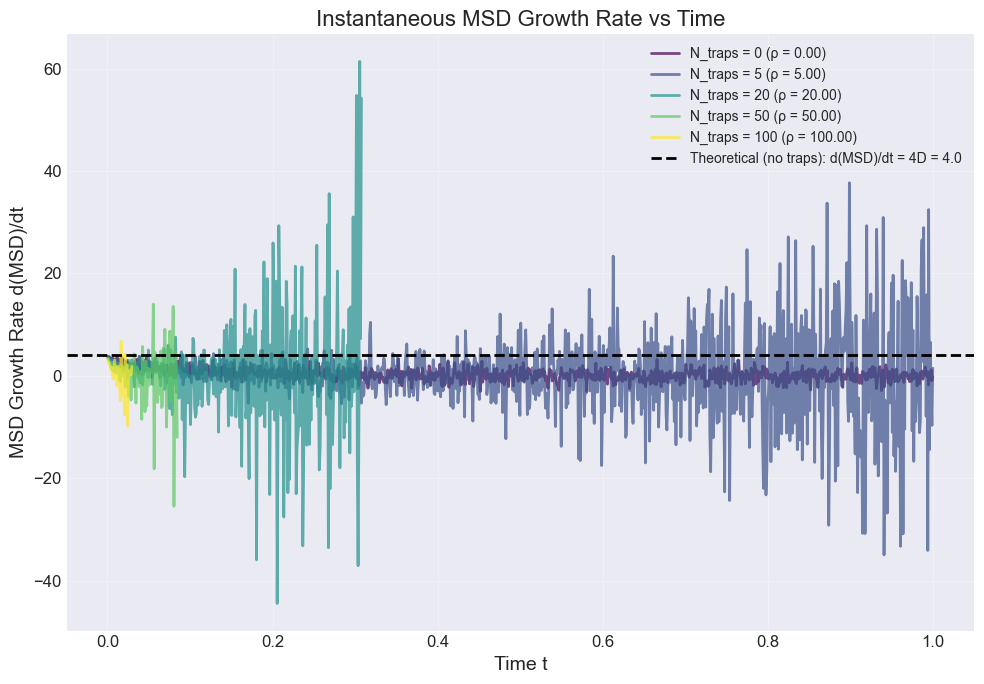

In [19]:
# Compute instantaneous MSD growth rate (derivative)
# This shows how the diffusion speed changes over time

fig, ax = plt.subplots(figsize=(10, 7))

colors = plt.cm.viridis(np.linspace(0, 1, len(trap_counts)))

for idx, N_traps in enumerate(trap_counts):
    results = all_results[N_traps]
    times = results['times']
    msd = results['msd']
    survival = results['survival']
    
    # Compute derivative (growth rate)
    # d(MSD)/dt ≈ (MSD[i+1] - MSD[i]) / dt
    valid_mask = (survival > 0) & ~np.isnan(msd)
    
    if np.sum(valid_mask) > 1:
        times_valid = times[valid_mask]
        msd_valid = msd[valid_mask]
        
        # Compute derivative
        dmsd_dt = np.diff(msd_valid) / np.diff(times_valid)
        times_deriv = (times_valid[:-1] + times_valid[1:]) / 2
        
        trap_density = N_traps / (L**2)
        label = f'N_traps = {N_traps} (ρ = {trap_density:.2f})'
        
        ax.plot(times_deriv, dmsd_dt, color=colors[idx], linewidth=2, 
               label=label, alpha=0.7)

# Theoretical value for pure diffusion: d(MSD)/dt = 4D
ax.axhline(y=4*D, color='k', linestyle='--', linewidth=2, 
          label=f'Theoretical (no traps): d(MSD)/dt = 4D = {4*D}')

ax.set_xlabel('Time t', fontsize=14)
ax.set_ylabel('MSD Growth Rate d(MSD)/dt', fontsize=14)
ax.set_title('Instantaneous MSD Growth Rate vs Time', fontsize=16)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


The MSD growth rate shows how fast the mean-square displacement increases. For pure diffusion, it should be constant at 4D. With traps, the growth rate decreases over time as particles are absorbed, and the remaining particles have reduced effective diffusion.


### 5.10 Fraction of Survived Particles vs Trap Density


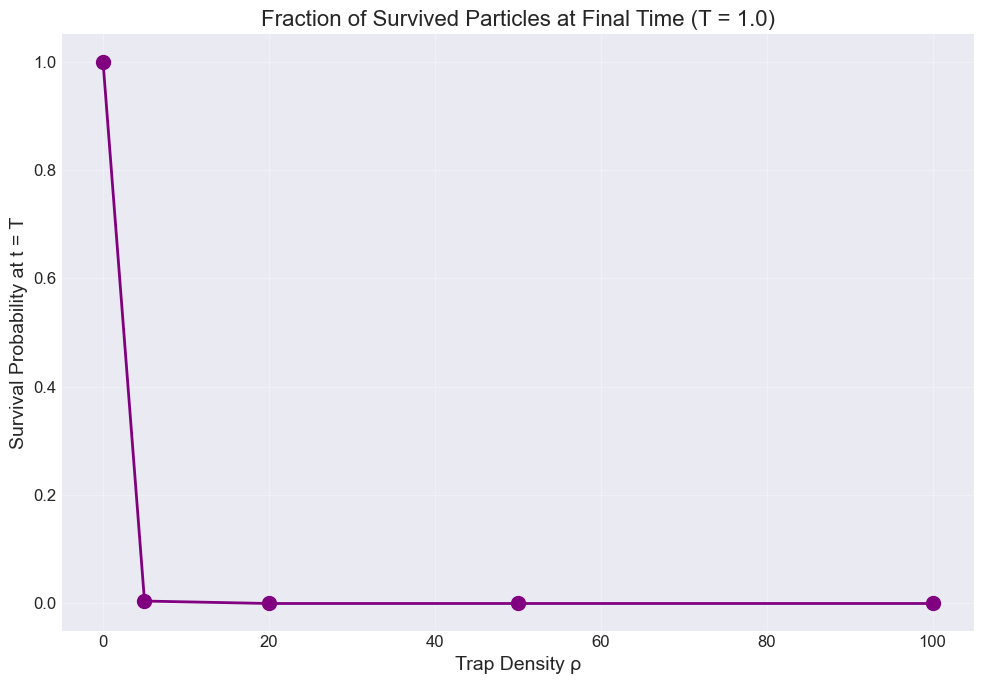

Survival probability at final time:
  ρ = 0.00: S(T) = 1.0000 (100.0% survived)
  ρ = 5.00: S(T) = 0.0045 (0.4% survived)
  ρ = 20.00: S(T) = 0.0000 (0.0% survived)
  ρ = 50.00: S(T) = 0.0000 (0.0% survived)
  ρ = 100.00: S(T) = 0.0000 (0.0% survived)


In [20]:
# Plot fraction of particles that survived until final time vs trap density
fig, ax = plt.subplots(figsize=(10, 7))

trap_densities = []
survival_final = []

for N_traps in trap_counts:
    results = all_results[N_traps]
    trap_density = N_traps / (L**2)
    
    # Survival probability at final time
    survival_at_T = results['survival'][-1]
    
    trap_densities.append(trap_density)
    survival_final.append(survival_at_T)

ax.plot(trap_densities, survival_final, 'o-', linewidth=2, markersize=10, color='purple')
ax.set_xlabel('Trap Density ρ', fontsize=14)
ax.set_ylabel('Survival Probability at t = T', fontsize=14)
ax.set_title(f'Fraction of Survived Particles at Final Time (T = {T})', fontsize=16)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

# Print values
print("Survival probability at final time:")
for rho, surv in zip(trap_densities, survival_final):
    print(f"  ρ = {rho:.2f}: S(T) = {surv:.4f} ({surv*100:.1f}% survived)")


 This plot shows how trap density affects the fraction of particles that survive until the end of the simulation. As trap density increases, fewer particles survive, demonstrating the increasing probability of trap encounters.


## 6. Discussion

### 6.1 Main Trends

Our simulations reveal several key trends in the diffusion of particles in a 2D domain with traps:

1. **Mean Square Displacement (MSD)**:
   - For zero traps, the MSD grows linearly with time, following the theoretical prediction $\text{MSD}(t) = 4Dt$.
   - As trap density increases, the MSD growth slows down. Initially, the growth may still be approximately linear (Fickean), but with a reduced effective diffusion coefficient.
   - At longer times, the MSD curves bend downward because fewer particles survive, and the MSD is computed only over surviving particles.

2. **Survival Probability**:
   - With no traps, all particles survive indefinitely.
   - As trap density increases, survival probability decays faster, approximately exponentially for moderate trap densities.
   - The decay rate increases with trap density, reflecting the higher probability of trap encounters.

3. **Effective Diffusion Coefficient**:
   - The effective diffusion coefficient decreases monotonically with increasing trap density.
   - This quantifies how traps reduce the ability of particles to explore space.

4. **Lifetime Distributions**:
   - The mean time to absorption decreases with increasing trap density.
   - The distribution becomes more concentrated at short times for high trap densities.

### 6.2 Physical Interpretation

Traps act as **sinks** that remove particles from the system. This has two main effects:

1. **Reduced exploration**: Particles that survive are those that have not yet encountered traps. However, the presence of traps creates "forbidden" regions, effectively reducing the accessible space and slowing diffusion.

2. **Population dynamics**: As particles are absorbed, the population of surviving particles decreases. The MSD is computed only over surviving particles, so at long times, when few particles remain, the MSD reflects the behavior of a small, possibly biased sample.


### 6.4 Limitations and Numerical Considerations

1. **Time step**: We use a fixed time step $\Delta t = 10^{-3}$. Smaller time steps would improve accuracy but increase computation time.

2. **Boundary effects**: Reflecting boundaries may affect results, especially for long trajectories. Periodic boundaries could be an alternative.

3. **Trap overlap**: We do not prevent traps from overlapping. For very high trap densities, overlapping traps effectively create larger absorbing regions.

4. **Finite domain**: The finite domain size $L$ limits the maximum MSD. For very long times, particles may reach the boundaries frequently.

5. **Initial conditions**: All particles start at random positions. Starting all particles at the same point (e.g., center) could reveal different behavior.

6. **Statistics**: We simulate 2000 particles per configuration. More particles would improve statistical accuracy, especially for high trap densities where few particles survive.


## 7. Conclusions

In this project, we simulated the diffusion of particles in a 2D domain with circular absorbing traps and investigated how the mean-square displacement (MSD) and survival probability depend on trap density. Our main findings are:

1. **Pure diffusion (no traps)**: The simulation reproduces normal 2D diffusion with MSD growing linearly as $\text{MSD}(t) = 4Dt$, in agreement with theoretical predictions.

2. **Effect of trap density**: Increasing trap density causes:
   - Earlier absorption of particles (decreased survival probability)
   - Slower MSD growth for surviving particles (reduced effective diffusion coefficient)
   - Shorter mean lifetimes

3. **Quantitative relationship**: The effective diffusion coefficient decreases monotonically with trap density, quantifying how traps reduce spatial exploration.

4. **Population dynamics**: The survival probability decays approximately exponentially for moderate trap densities, with faster decay for higher trap densities.

5. **Spatial exploration**: Heatmaps of visited positions show that high trap densities restrict particle exploration, with particles being absorbed before exploring much of the domain.

**Trap density strongly affects both the spatial spread and the survival probability of diffusing particles.** This has implications for understanding transport in heterogeneous media, such as porous materials, biological environments, and complex fluids.

Finally summarizing in last few paragraphs we can say, our simplified absorbing-trap model provides a clear demonstration of how obstacles affect diffusion, though it differs from the deep-trap model in Mora & Pomeau (2018), where particles can escape traps and exhibit Fickean but non-Gaussian diffusion.

In this project, we investigated two-dimensional Brownian motion in a bounded domain in the presence of randomly distributed absorbing traps. Using Monte Carlo simulations of thousands of trajectories, we quantified how trap density influences both the mean square displacement (MSD) of surviving particles and their survival probability over time.

In the absence of traps, the MSD grew linearly, consistent with the theoretical prediction for free diffusion in 2D. Introducing traps did not affect the early-time dynamics, but strongly altered the long-time behavior: MSD curves bent downward due to progressive absorption of trajectories, and the survival probability decayed at a rate determined by trap density. Higher trap densities produced shorter particle lifetimes and significantly reduced spatial exploration.

These results demonstrate how localized absorbing defects effectively lower the apparent diffusivity of a medium, despite the microscopic dynamics of individual particles remaining unchanged. The model captures essential features of diffusion-limited reactions and transport in heterogeneous or porous materials, illustrating how stochastic processes can produce markedly different macroscopic behaviors under simple environmental constraints.
